# Francia-Metadata

This notebook contains visualisations of the Francia metadata. It uses the python3 libraries: `numpy, pandas, matplotlib and seaborn`.


In [1]:
import re
import pandas as pd
import numpy as np
from scripts.plot_vis import visualize_data

all_francia = pd.read_csv('..data/metadata/all_francia.csv', encoding='utf8')
all_francia.drop(list(filter(lambda x: x!=-1,
                             [i if v['doc_type'] in ('rezensionen', 'nekrologe', 'dokumentation', 'jahresbericht', 'aus_der_arbeit_des_dhip', 'kurzbesprechungen', 'vorwort', 'prosopographica', 'notices_critiques', 'prosopographica_burgundica', 'sources_hagiographiques_de_la_gaule') else -1 for i, v in all_francia.iterrows()])),
                 inplace=True)
ateliers = pd.read_excel('../data/metadata/francia_ateliers_v1.xlsx')
ateliers = ateliers.loc[ateliers.epoche != 'löschen']

In [2]:
atelier_dict = {a['title']: a['epoche'] for _, a in ateliers.iterrows()}

epoche = []
for _, a in all_francia.iterrows():
    epoche.append(atelier_dict[a['title']] if a['title'] in atelier_dict.keys() and not pd.isna(atelier_dict[a['title']]) else a['epoche'])
all_francia['epoche'] = epoche
all_francia['epoche'] = [e.strip().upper() if type(e) is str else '' for e in all_francia['epoche']]
all_francia = all_francia.loc[all_francia.epoche != '']
all_francia['Anzahl_Seiten'] = [int(i.strip('(').strip(')').split(', ')[1]) - int(i.strip('(').strip(')').split(', ')[0]) for i in all_francia['pages']]
translate_language = {'Deutsch': 'Deutsch', 'Français': 'Französisch', 'English': 'Englisch'}
all_francia['language'] = [translate_language[l] for l in all_francia['language']]
all_francia = all_francia[['year', 'volume', 'title', 'authors', 'gender', 'pages', 'Anzahl_Seiten', 'doc_type', 'n', 'language', 'epoche']]

In [3]:
set(all_francia['language'])

{'Deutsch', 'Englisch', 'Französisch'}

## Epoche
The visualizations are based on collections of Francia-Articles in the three languages: German, French and English. All values are smoothed over a three years period and in the first visualization per language the distribution over the years are created based on the number of pages per epoche and in the second it is grouped by the number of articles per epoche per year.

In [4]:
language_tables = ['Deutsch', 'Französisch', 'Englisch']
"""
The excel-tables containing the metadata of the articles.
"""
visualization_functions = {'sum': {'title': 'Anzahl der Seiten pro Epoche über die Jahre', 'y': 'Anzahl_Seiten'},
                           'count': {'title': 'Anzahl der Artikel pro Epoche über die Jahre', 'y': 'Titel'}}
"""
The functions for grouping the data per year and epoche.
"""
files_path = {'Deutsch': '../data/metadata/francia_deutsch_v5.xlsx',
              'Französisch': '../data/metadata/francia_francais_v2.xlsx',
              'Englisch': '../data/metadata/francia_english_v4.xlsx'}
articles_epoche = pd.DataFrame()
for l in language_tables:
    data_articles = pd.read_excel(files_path[l])
    ### First the leading and ending whitespaces have to be removed.
    for col in list(data_articles):
        data_articles[col] = list(map(lambda x: x.strip() if type(x) is str else x, data_articles[col]))
    data_articles['Epoche'] = list(map(lambda x: x.upper(), data_articles['Epoche']))
    data_articles['Sprache'] = [l for _ in range(data_articles.shape[0])]
    articles_epoche = pd.concat([articles_epoche, data_articles])
articles_epoche = all_francia

['FNZ', 'MA', 'NNG', 'Ü']
['NNG', 'FNZ', 'MA', 'Ü']


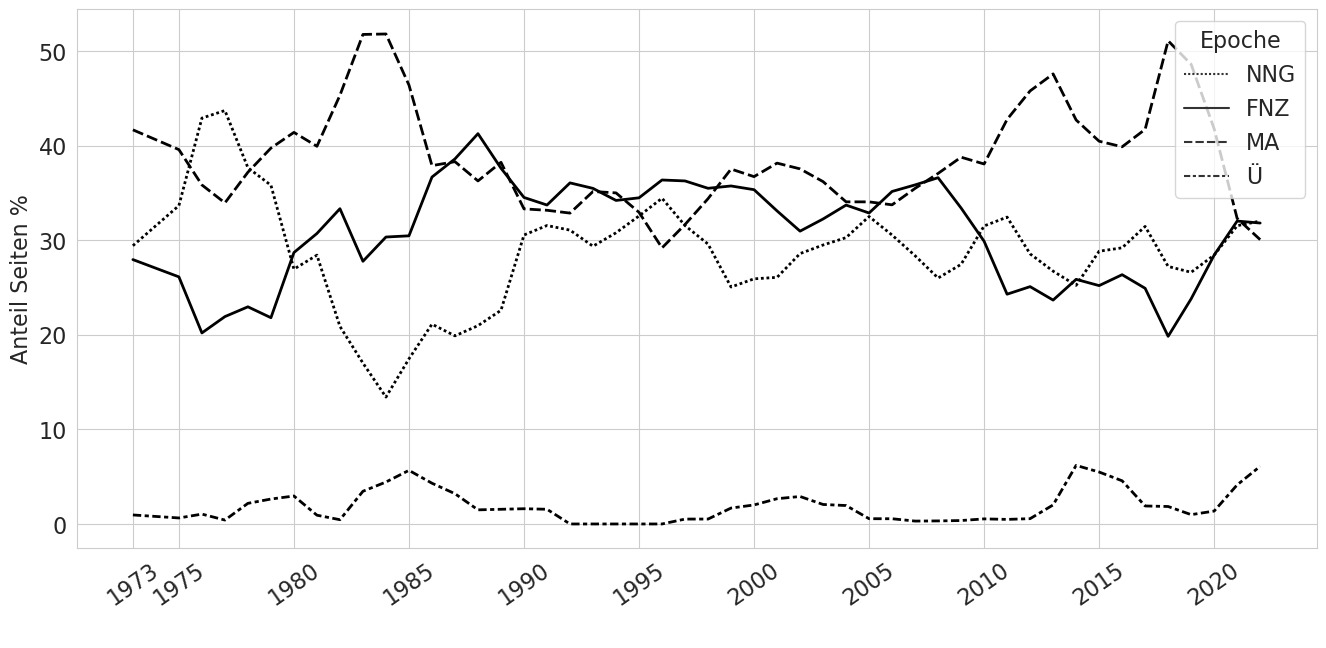

['FNZ', 'MA', 'NNG', 'Ü']
['NNG', 'FNZ', 'MA', 'Ü']


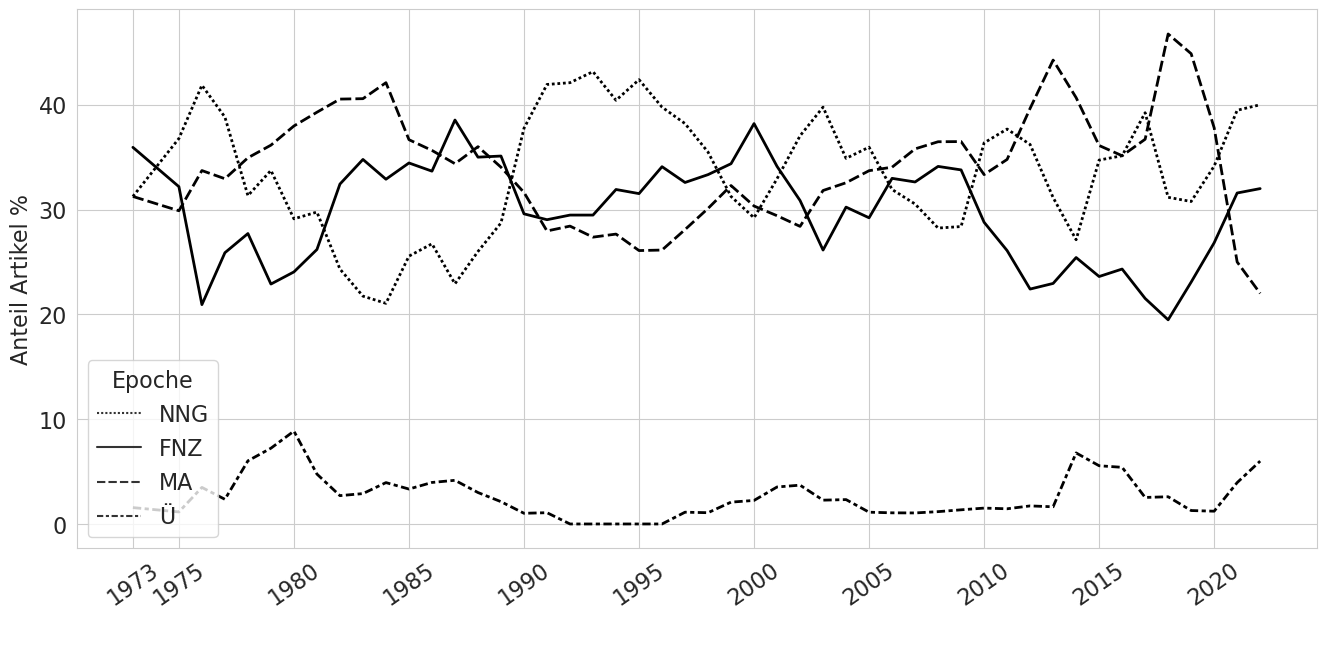

,year,epoche,title
0,1973,FNZ,35.937500
1,1975,FNZ,32.183908
2,1976,FNZ,20.930233
3,1977,FNZ,25.882353
4,1978,FNZ,27.710843
...,...,...,...
191,2018,Ü,2.597403
192,2019,Ü,1.282051
193,2020,Ü,1.219512
194,2021,Ü,3.947368


In [5]:
visualize_data(data=articles_epoche, x='year', y='Anzahl_Seiten', x_label=' ', y_label='Anteil Seiten %', group='epoche', smooth_y=3,
               title='Abb_2-Anteil Seiten pro Epoche', set_null_values=True, group_func='sum', save=True, show_title=False, relative=True, percent=True)
visualize_data(data=articles_epoche, x='year', y='title', x_label=' ', y_label='Anteil Artikel %', group='epoche', smooth_y=3,
               title='Abb_1-Anteil Artikel pro Epoche', set_null_values=True,group_func='count', save=True, show_title=False, relative=True, percent=True)

In [6]:
articles_epoche.loc[articles_epoche.epoche == 'NNG'].groupby(by=["language"], as_index=False).count()[['language', 'title']]

,language,title
0,Deutsch,248
1,Englisch,40
2,Französisch,169


# Authors
The following visualizations are showing the development of the author-genders over the years in the Francia. It uses therefore the `authors_francia.csv` file in the directory `../data/metadata/`.

In [7]:
author_gender = pd.read_csv('../data/metadata//authors_francia.csv', index_col='authorID', encoding='utf8')
author_gender = {v['author'].strip(): v['gender'].strip() if type(v['gender']) is str else '' for _, v in author_gender.iterrows()}
pd.Series(author_gender)

Achim Th. Hack               m
Achim Thomas Hack            m
Adalbert de Vogüé            m
Adelheid Krah                f
Adolf Kimmel                 m
                            ..
C. Bettina Schmidt           f
Claude d&#039;Abzac-Epezy    m
Liliane d&#039;Artagnan      f
David Gallo                  m
Nicolas Patin                m
Length: 2072, dtype: object

The tables with the articles must now be enriched by the author-gender information. Therefore, a new column will be added called `author_gender`. It is important to note, that in the following concept in article with more than one author are counting for every author. So, there may be more pages counted per year as actually are existing.

In [8]:
articles_author = pd.DataFrame()
for l in language_tables:
    tmp = pd.read_excel(files_path[l])
    tmp['Sprache'] = [l for _ in range(tmp.shape[0])]
    articles_author = pd.concat([articles_author, tmp])

double_entries = []
num_double = 0
for _, article in articles_author.iterrows():
    if ', ' in article['Autor_innen']:
        authors = article['Autor_innen'].strip('[').strip(']').split(', ')
        authors = list(map(lambda x: x.strip("'"), authors))
        for a in authors[1:]:
            double_entries.append({i: article[i] for i in list(articles_author)})
            double_entries[-1]['Autor_innen'] = a
        num_double += 1
        # article['Autor_innen'] = authors[0]
print(fr'Number of multi-author articles: {num_double}')
articles_author['Autor_innen'] = list(map(lambda x: x if ', ' not in x else x.strip('[').strip(']').split(', ')[0].strip("'"),
                                          articles_author['Autor_innen'].tolist()))
articles_author = pd.concat([articles_author, pd.DataFrame(double_entries)])
gender = []
for _, article in articles_author.iterrows():
    gender.append(author_gender[article['Autor_innen'].strip()])

articles_author['Geschlecht'] = gender
articles_author['Epoche'] = [i.strip().upper() for i in articles_author['Epoche'].tolist()]
articles_author

Number of multi-author articles: 44


,Jahr,Ausgabe,Titel,Autor_innen,Seiten(von-bis),Anzahl_Seiten,Epoche,Rubrik,Notizen,Sprache,Geschlecht
0,1973,1-0,Neue_Aspekte_der_biographischen_und,Martin Heinzelmann,"(27, 44)",17,MA,A,NaN,Deutsch,m
1,1973,1-0,"Die_Collectio_vetus_Gallica,_die",Hubert Mordek,"(45, 61)",16,MA,A,NaN,Deutsch,m
2,1973,1-0,Das_Privileg_des_Bischofs_Berthefrid,Eugen Ewig,"(62, 114)",52,MA,A,NaN,Deutsch,m
3,1973,1-0,Das_Geburtsdatum_Karls_des_Großen,Karl Ferdinand Werner,"(115, 157)",42,MA,A,NaN,Deutsch,m
4,1973,1-0,Abaelards_Stellung_zur_Kirchenreform_Eine,Jürgen Miethke,"(158, 192)",34,MA,A,NaN,Deutsch,m
...,...,...,...,...,...,...,...,...,...,...,...
45,1999,26-3,The_Shadows_of_Total_War,Dierck Walter,"(171, 174)",3,NNG,F,NaN,Englisch,m
46,2015,42-0,Landscapes_of_Defense_At_the,David S. Bachrach,"(231, 252)",21,MA,F,NaN,Englisch,m
47,2016,43-0,Familiar_Marvels_French_and_German,Loïc Chollet,"(41, 62)",21,MA,A,NaN,Englisch,m
48,2017,44-0,Nithard_as_a_Military_Historian,David S. Bachrach,"(29, 55)",26,MA,A,NaN,Englisch,m


Number of multi-author articles: 49
[]
['f', 'm']
['f', 'm']


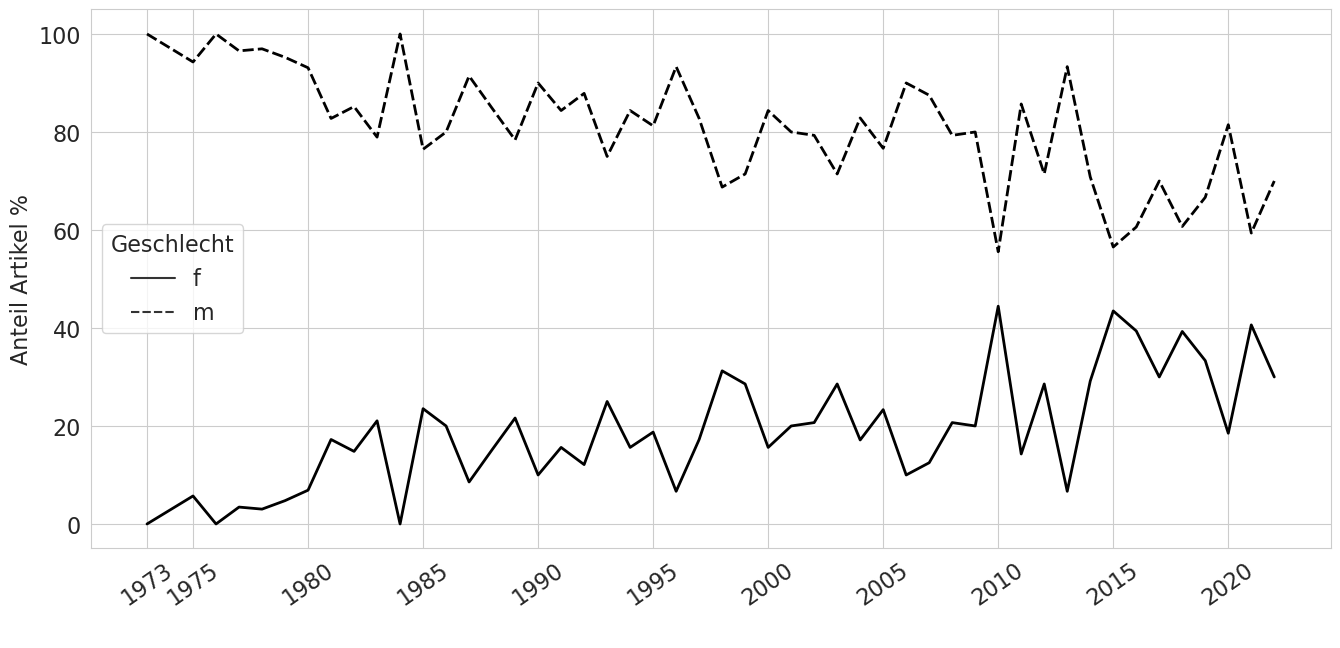

In [9]:

double_entries = []
num_double = 0
for _, article in all_francia.iterrows():
    if ', ' in article['authors']:
        authors = article['authors'].strip('[').strip(']').split(', ')
        authors = list(map(lambda x: x.strip("'"), authors))
        for a in authors[1:]:
            double_entries.append({i: article[i] for i in list(all_francia)})
            double_entries[-1]['authors'] = a
        num_double += 1
print(fr'Number of multi-author articles: {num_double}')
        # article['Autor_innen'] = authors[0]
all_francia['authors'] = list(map(lambda x: x if ', ' not in x else x.strip('[').strip(']').split(', ')[0].strip("'"),
                                          all_francia['authors'].tolist()))
all_francia = pd.concat([all_francia, pd.DataFrame(double_entries)])
gender = []
ids = []
for i, article in all_francia.iterrows():
    try:
        gender.append(author_gender[article['authors'].strip()])
    except KeyError:
        print(f'Couldn\'t find Author "{article["authors"].strip()}"')
    if author_gender[article['authors'].strip()] not in ('f', 'm'):
        ids.append(i)
print(ids)
all_francia['Geschlecht'] = gender
all_francia.drop(ids, inplace=True)
df = visualize_data(all_francia, x='year', y='title', group='Geschlecht',
                    title='Abb_4-Verhältnis Autorinnen Autoren', group_func='count', y_label="Anteil Artikel %", x_label=" ", relative=True, show_title=False, smooth_y=1, save=True, percent=True)

In [10]:
all_francia['epoche'] = [i.strip().replace(', SA', '').upper().replace(', FMA', '') if type(i) is str else i for i in all_francia['epoche'].tolist()]
all_francia.groupby(by=['epoche', 'Geschlecht'], as_index=False).count()[['epoche', 'Geschlecht', 'title']]

,epoche,Geschlecht,title
0,FNZ,f,75
1,FNZ,m,352
2,MA,f,89
3,MA,m,393
4,NNG,f,100
5,NNG,m,376
6,Ü,f,7
7,Ü,m,31


In [11]:
all_francia.groupby(by="Geschlecht", as_index=False).count()[['Geschlecht', 'title']]

,Geschlecht,title
0,f,271
1,m,1152


In [12]:
print(24/(24+151))
print(151/(24+151))

0.13714285714285715
0.8628571428571429


In [13]:
all_francia.groupby(by=['epoche'], as_index=False).count()[['epoche', 'title']]

,epoche,title
0,FNZ,427
1,MA,482
2,NNG,476
3,Ü,38


In [14]:

after_90 = all_francia.loc[all_francia.year < 1990]
after_90 = after_90.loc[after_90.year >= 1980]
print(after_90[['Geschlecht', 'title', 'year']])
after_90 = after_90.groupby(by=['Geschlecht'], as_index=False).count()[['Geschlecht', 'title']]
after_90['relative'] = [i/np.sum(after_90['title']) for i in after_90['title']]
after_90

    Geschlecht                                              title  year
604          m              Steuer und Zoll in der Merowingerzeit  1980
605          f     Studien zum Reimser Polyptychum Sancti Remigii  1980
606          m  Heinrich Heines ursprüngliche Wirkung auf die ...  1980
607          m  Die deutsche Kolonialgesellschaft in der Agadi...  1980
608          m  Zwischen »republikanischem« und »proletarische...  1980
..         ...                                                ...   ...
5            m  Gregor von Tours und der »rote Sirius«. Unters...  1988
6            m  La Franche-Comté entre le Royaume et l'Empire ...  1988
7            m  La Franche-Comté entre le Royaume et l'Empire ...  1988
8            m  Les sources hagiographiques narratives composé...  1988
9            m  Les sources hagiographiques narratives composé...  1988

[302 rows x 3 columns]


,Geschlecht,title,relative
0,f,46,0.152318
1,m,256,0.847682


# Sprachen
Dieser Abschnitt analysiert die Sprachen in der Francia.

In [15]:
all_francia['Sprache'] = list(map(lambda x: x.replace('Français', 'Französisch').replace('English', 'Englisch'), all_francia['language'].tolist()))
all_francia

,year,volume,title,authors,gender,pages,Anzahl_Seiten,doc_type,n,language,epoche,Geschlecht,Sprache
1,1973,1-0,Frühe Reformforderungen unter Ludwig XIV. Der ...,Klaus Malettke,m,"(325, 349)",24,aufsaetze,1,Deutsch,FNZ,m,Deutsch
2,1973,1-0,Luxuskäufe des Münchener Hofes in Paris (1718-...,Peter Claus Hartmann,m,"(350, 360)",10,aufsaetze,1,Deutsch,FNZ,m,Deutsch
3,1973,1-0,"Neues zur Biograpie Mablys: Seine ""materiellen...",Peter Friedemann,m,"(361, 368)",7,aufsaetze,1,Deutsch,FNZ,m,Deutsch
4,1973,1-0,Die Rheinländer und Napoleon,Karl-Georg Faber,m,"(374, 394)",20,aufsaetze,1,Deutsch,FNZ,m,Deutsch
5,1973,1-0,"Graf Schlabrendorff, ein deutscher Kritiker Na...",Karl Hammer,m,"(402, 413)",11,aufsaetze,1,Deutsch,FNZ,m,Deutsch
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,2018,45-0,»Aller Dienst an der Grenze ist staatspolizeil...,Lena Haase,m,"(293, 323)",30,zur_forschungsgeschichte_und_methodendiskussion,1,Deutsch,NNG,f,Deutsch
52,2019,46-0,La paix diocésaine du Toulousain en 1163,Nicolas Ruffini-Ronzani,m,"(77, 104)",27,aufsaetze,1,Französisch,MA,m,Französisch
53,2020,47-0,»Mein Kampf« en France,Nicolas Patin,NaN,"(419, 426)",7,atelier,1,Französisch,NNG,m,Französisch
54,2021,48-0,The Politics of Bodies at the Early Modern Court,Tom Tölle,f,"(315, 334)",19,atelier,1,Englisch,FNZ,m,Englisch


['Deutsch', 'Englisch', 'Französisch']
['Deutsch', 'Französisch', 'Englisch']


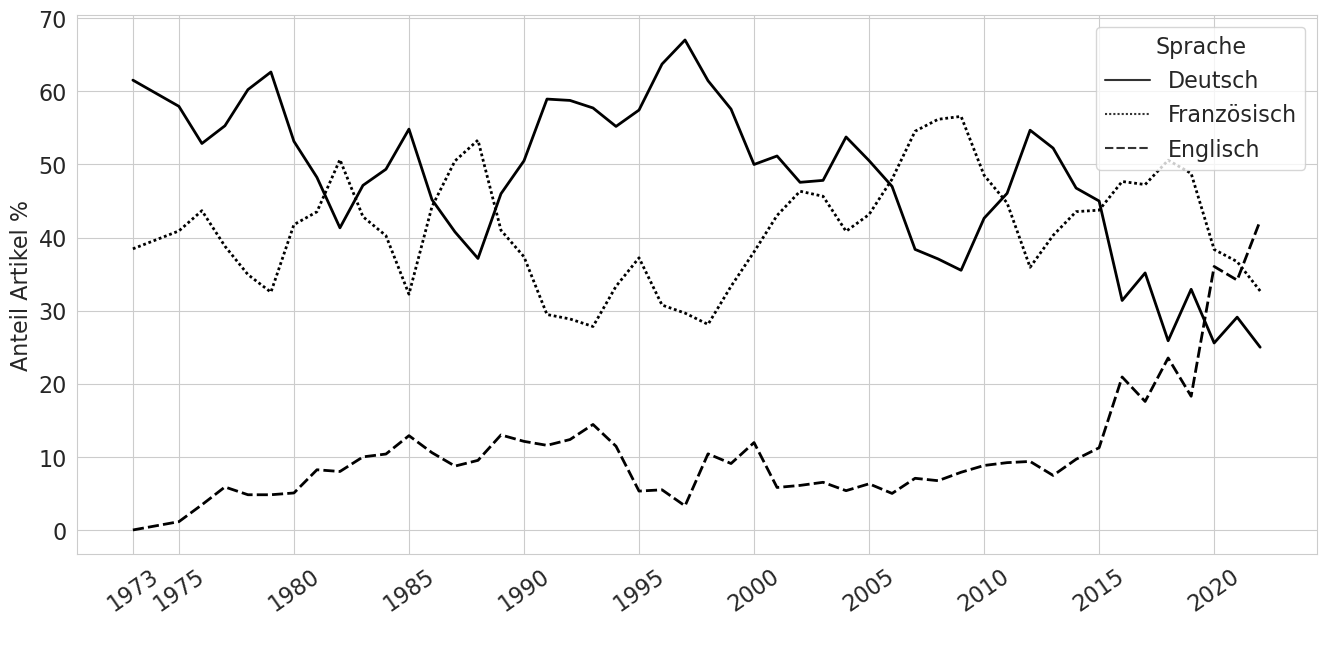

,year,Sprache,title
0,1973,Deutsch,61.538462
1,1975,Deutsch,57.954545
2,1976,Deutsch,52.873563
3,1977,Deutsch,55.294118
4,1978,Deutsch,60.240964
...,...,...,...
142,2018,Französisch,50.588235
143,2019,Französisch,48.780488
144,2020,Französisch,38.372093
145,2021,Französisch,36.708861


In [16]:
visualize_data(data=all_francia, x='year', y='title', group='Sprache', x_label=' ', y_label='Anteil Artikel %', title='Abb_3-Anteil Sprachen', relative=True, smooth_y=3, colors=False, show_title=False, save=True)

In [17]:
all_francia.loc[all_francia.doc_type == 'atelier'].groupby(by='language', as_index=False).count()[['language', 'title']]

,language,title
0,Deutsch,24
1,Englisch,29
2,Französisch,54


# Begriffe
Der folgende Abschnitt dient der Untersuchung der zeitlichen Entwicklung von Begriffen im Corpus.

In [18]:
fulltexts = []
for _, v in articles_author.iterrows():
    if v['Sprache'] == 'Deutsch':
        path = '../data/corpus/de'
        pages = v["Seiten(von-bis)"].strip(')').strip('(').split(', ')
        file_name = f'{path}/{v["Ausgabe"]}_{v["Titel"]}-_{pages[0]}-{pages[1]}.txt'
        try:
            with open(file_name, encoding='utf8') as f:
                fulltexts.append(f.read())
        except (FileExistsError, FileNotFoundError):
            print(f'\tCouldn\'t find "{file_name}"')
            fulltexts.append('')
    elif v['Sprache'] == 'Französisch':
        path = '../data/corpus/fr'
        pages = v["Seiten(von-bis)"].strip(')').strip('(').split(', ')
        volume = v["Ausgabe"]
        volume = v["Ausgabe"] if v["Ausgabe"][-1] != '0' else v["Ausgabe"].split('-')[0]
        volume = volume if len(volume) > 1 else '0' + volume
        file_name = f'{path}/{volume}_{v["Titel"]}-_{pages[0]}-{pages[1]}.txt'
        try:
            with open(file_name, encoding='utf8') as f:
                fulltexts.append(f.read())
        except (FileExistsError, FileNotFoundError):
            print(f'\tCouldn\'t find "{file_name}"')
            fulltexts.append('')
    else:
        fulltexts.append('')
articles_author['Fulltext'] = fulltexts
articles_author['num_tokens'] = [len(f) for f in fulltexts]
articles_author

	Couldn't find "../00_korpus_metadaten/deutsche_texte/final_02/32-3_L'Allemagne_nouvelle_oder_l'Allemagne_éternelle-_139-160.txt"


,Jahr,Ausgabe,Titel,Autor_innen,Seiten(von-bis),Anzahl_Seiten,Epoche,Rubrik,Notizen,Sprache,Geschlecht,Fulltext,num_tokens
0,1973,1-0,Neue_Aspekte_der_biographischen_und,Martin Heinzelmann,"(27, 44)",17,MA,A,NaN,Deutsch,m,MARTIN HEINZELMANN\n\nNEUE ASPEKTE DER BIOGRAP...,52518
1,1973,1-0,"Die_Collectio_vetus_Gallica,_die",Hubert Mordek,"(45, 61)",16,MA,A,NaN,Deutsch,m,HUBERT MORDEK\n\nDIE COLLECTIO VETUS GALLICA \...,42390
2,1973,1-0,Das_Privileg_des_Bischofs_Berthefrid,Eugen Ewig,"(62, 114)",52,MA,A,NaN,Deutsch,m,EUGEN EWIG\n\nDAS PRIVILEG DES BISCHOFS BERTHE...,123099
3,1973,1-0,Das_Geburtsdatum_Karls_des_Großen,Karl Ferdinand Werner,"(115, 157)",42,MA,A,NaN,Deutsch,m,KARL FERDINAND WERNER\n\nDAS GEBURTSDATUM KARL...,130184
4,1973,1-0,Abaelards_Stellung_zur_Kirchenreform_Eine,Jürgen Miethke,"(158, 192)",34,MA,A,NaN,Deutsch,m,JÜRGEN MIETHKE\n\nABAELARDS STELLUNG ZUR KIRCH...,77438
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,1999,26-3,The_Shadows_of_Total_War,Dierck Walter,"(171, 174)",3,NNG,F,NaN,Englisch,m,,0
46,2015,42-0,Landscapes_of_Defense_At_the,David S. Bachrach,"(231, 252)",21,MA,F,NaN,Englisch,m,,0
47,2016,43-0,Familiar_Marvels_French_and_German,Loïc Chollet,"(41, 62)",21,MA,A,NaN,Englisch,m,,0
48,2017,44-0,Nithard_as_a_Military_Historian,David S. Bachrach,"(29, 55)",26,MA,A,NaN,Englisch,m,,0


In [19]:
words = [r'[Mm]entalit[a-zA-ZäöüÄÖÜ]*']
language = ('Deutsch', 'Französisch', 'Englisch')
tmp = []
word_list = []
for _, v in articles_author.iterrows():
    word_list.append(np.sum([len(re.findall(w, v['Fulltext'])) for w in words]))
articles_author['word'] = word_list

In [20]:
words_lang = articles_author.loc[articles_author.Fulltext != ''].copy()
words_lang

,Jahr,Ausgabe,Titel,Autor_innen,Seiten(von-bis),Anzahl_Seiten,Epoche,Rubrik,Notizen,Sprache,Geschlecht,Fulltext,num_tokens,word
0,1973,1-0,Neue_Aspekte_der_biographischen_und,Martin Heinzelmann,"(27, 44)",17,MA,A,NaN,Deutsch,m,MARTIN HEINZELMANN\n\nNEUE ASPEKTE DER BIOGRAP...,52518,0
1,1973,1-0,"Die_Collectio_vetus_Gallica,_die",Hubert Mordek,"(45, 61)",16,MA,A,NaN,Deutsch,m,HUBERT MORDEK\n\nDIE COLLECTIO VETUS GALLICA \...,42390,0
2,1973,1-0,Das_Privileg_des_Bischofs_Berthefrid,Eugen Ewig,"(62, 114)",52,MA,A,NaN,Deutsch,m,EUGEN EWIG\n\nDAS PRIVILEG DES BISCHOFS BERTHE...,123099,0
3,1973,1-0,Das_Geburtsdatum_Karls_des_Großen,Karl Ferdinand Werner,"(115, 157)",42,MA,A,NaN,Deutsch,m,KARL FERDINAND WERNER\n\nDAS GEBURTSDATUM KARL...,130184,0
4,1973,1-0,Abaelards_Stellung_zur_Kirchenreform_Eine,Jürgen Miethke,"(158, 192)",34,MA,A,NaN,Deutsch,m,JÜRGEN MIETHKE\n\nABAELARDS STELLUNG ZUR KIRCH...,77438,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,2015,42-0,Bibliotheca_Palatina_–_digital_La,Karin Zimmermann,"(291, 306)",15,Ü,F,NaN,Französisch,f,\nBIBLIOTHECA PALATINA DIGITAL\nLa reconstitu...,46635,0
40,2016,43-0,Les_Allemands_à_la_bataille,Françoise Lainé,"(353, 365)",12,MA,M,NaN,Französisch,f,\n\nCuris GIVEN-WILSON — FRANGOISE LAINE\n\nL...,43514,0
41,2017,44-0,Du_bon_usage_du_compte,Antoine Calvet,"(245, 255)",10,Ü,F,NaN,Französisch,m,Jo BLANCHARD — ANTOINE CALVET\n\nDU BON USAG...,35465,0
42,2017,44-0,Les_relations_entre_la_cour,Matthieu Gellard,"(295, 307)",12,FNZ,F,NaN,Französisch,m,VLADIMIR CHICHKINE — MATTHIEU GELLARD\n\nLES ...,41631,0


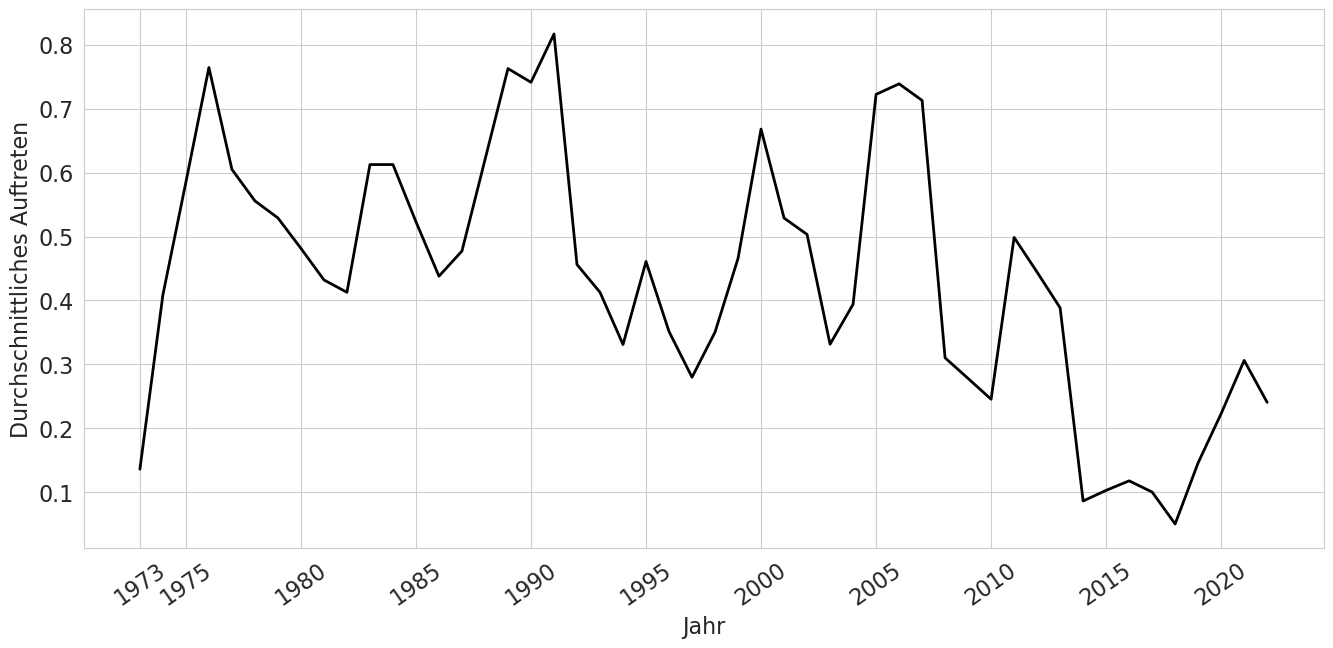

,Jahr,word
0,1973,0.135714
1,1974,0.408658
2,1975,0.585201
3,1976,0.764618
4,1977,0.605166
5,1978,0.555783
6,1979,0.529101
7,1980,0.481481
8,1981,0.432099
9,1982,0.412698


In [21]:
visualize_data(data=words_lang, x='Jahr', y='word', group='', group_func='mean',
               y_label='Durchschnittliches Auftreten', colors=False, smooth_y=3)